# DigiLab 6 - Security-Constrained Optimal Power Flow
Author: Emil G. Melfald, University of South-Eastern Norway <br><br>

**Note**: PyPSA documentation and explanations for keywords when defining grid components is found [here](https://pypsa.readthedocs.io/en/latest/components.html).

## Prerequisites 
You must have completed **Assignment 1** in the EPE2316 course. That also includes Digilab 1 to 3. Familiarity with Digilab 4 and 5 is adviced. 

## Learning Objectives 
By the end of this notebook you should be able to: 
- Formulate the optimal power flow (OPF) optimization mathematically
- Define the constraints in OPF 
- Solve a simple system using scipy
- Use PyPSA to do OPF 

## Contents 
1. [Mathematical definition of OPF](#OPFDef)
2. [Defining OPF objective in Python](#ObjDefPy)
3. [OPF in a simple system using Scipy, no constraints](#OPFScipyNoCons) 
4. [Defining OPF constraints in Python](#Constraints)
5. [OPF in a simple system using Scipy, with constraints](#OPFScipyCons) 

In [2]:
import numpy as np 
from scipy.optimize import root, minimize 
import matplotlib.pyplot as plt 

# Mathematical definition of OPF
[](#OPFDef)
Optimal Power Flow (OPF) is similar to economic dispatch (ED) in that desicion variables such as the active power dispatch from generators should be determined. However, the main differences that will be done from ED are: 
- Another desicion variable is added, namely the voltage setpoint at PV buses. 
- The objective function changes from minimizing **cost of operation** to **minimizing power losses**. 

A general way of writing the OPF optimization problem is as follows. The decision variables ($P_{gi}$ and $V_{gi}$) is noted as $u$. $x$ is the power injection, and $y$ is the bus voltages and voltage angles. $\bf{G}$ is the equality constraints, e.g., the power flow error equations. $\bf{H}$ may be the voltage and line current limits. 
$$ \min_x f(u) $$

subject to

$$ \bf{G(x, u, y)} = 0 $$

$$ \bf{H(x, u, y)} \le 0 $$

In our case, $f(u)$ will be the total power losses in the grid. 

$$ f(u) = \sum P_{Loss} = \sum_{i=1}^{N_{bus}}\left[P_g^{i} - P_{d}^i\right]


# Defining OPF objective in Python
[](#ObjDefPy)

We will work with the following system throughout this notebook. 

![Image of the power system under study](Power_System_Drawing.png)

Defining the OPF starts with defining the power flow calculations. This may be done as we have done earlier in the course. One additional function is made, where the inputs are the desicion variables, $P_3$ and $V_3$ in this case, and returns the total system power losses.  

In [3]:
from numeric_data import Y_bus 

S_base = 100 # MVA 
V_base = 22 # kV 
I_base = (S_base*1e6)/(np.sqrt(3)*V_base*1e3) # A

th_vals = np.array([0.0, 0.0, 0.0], dtype=float) # Initial guess of voltage angles
V_vals = np.array([1.0, 1.0, 1.0], dtype=float) # Initial guess of voltage magnitudes
P_vals = np.array([0.0, -6.0, 3.0])/S_base 
Q_vals = np.array([0.0, -4.5, 0.0])/S_base 

In [4]:
def get_power_flow(th_vec, V_vec): 
    V_complex = V_vec*(np.cos(th_vec) + 1j*np.sin(th_vec))
    I_inj = Y_bus @ V_complex 
    S_inj = V_complex * I_inj.conj()
    P_res = np.real(S_inj)
    Q_res = np.imag(S_inj) 
    return P_res, Q_res

# Formulates the power flow error equations manually for our system
def power_flow_error(y, th_vals, V_vals, P_vals, Q_vals):
    th2, th3, V2 = y 
    th_vec = th_vals.copy()
    V_vec = V_vals.copy()
    th_vec[1] = th2 # The PQ bus has unknown voltage angle 
    th_vec[2] = th3 # The PV bus has unknown voltage angle
    V_vec[1] = V2 # The PQ bus has unknown voltage
    P_res, Q_res = get_power_flow(th_vec, V_vec)
    pf_error1 = P_res[1] - P_vals[1] # We know what P2 should be, therefore calculating error
    pf_error2 = P_res[2] - P_vals[2] # We know what P3 should be, therefore calculating error
    pf_error3 = Q_res[1] - Q_vals[1] # We know what Q2 should be, therefore calculating error
    return np.array([pf_error1, pf_error2, pf_error3])

def get_pf_sol(th_init, V_init, P_init, Q_init): 
    th_vals = th_init.copy()
    V_vals = V_init.copy()
    P_vals = P_init.copy()
    Q_vals = Q_init.copy()

    pf_sol = root(power_flow_error, x0=np.array([0.0, 0.0, 1.0]), args=(th_vals, V_vals, P_vals, Q_vals))
    th_vals[1] = pf_sol.x[0]
    th_vals[2] = pf_sol.x[1]
    V_vals[1]  = pf_sol.x[2]
    P_res, Q_res = get_power_flow(th_vals, V_vals) 
    return th_vals, V_vals, P_res, Q_res

# Assume our decision variables for OPF u = [P3, V3]
def objective_function(u, V1=1.0, P2=-6.0, Q2=-4.5): 
    P3, V3 = u 
    th_OPF = np.array([0.0, 0.0, 0.0], dtype=float) #initialize
    V_OPF = np.array([V1, 1.0, V3], dtype=float) 
    P_OPF = np.array([0.0, P2, P3])/S_base 
    Q_OPF = np.array([0.0, Q2, 0.0])/S_base 
    th_res, V_res, P_res, Q_res = get_pf_sol(th_OPF, V_OPF, P_OPF, Q_OPF)    
    return np.sum(P_res) # Returns the difference between P in and out, hence transmission losses

# OPF in a simple system using Scipy, no constraints
[](#OPFScipyNoCons)
 

In [5]:
# Trying one instance of P3, V3: 
P3_start = 3.0 # Start value 
V3_start = 1.0 
x0 = np.array([P3_start, V3_start])
P_loss = objective_function(x0, V1=1.0, P2=-6.0, Q2=-4.5)*S_base 
print(f"Power losses with P3={P3_start} MW, V3={V3_start} pu -> P_loss={P_loss}")

Power losses with P3=3.0 MW, V3=1.0 pu -> P_loss=0.11025694702333604


#### Contour plot of P_loss for different P3, V3 values

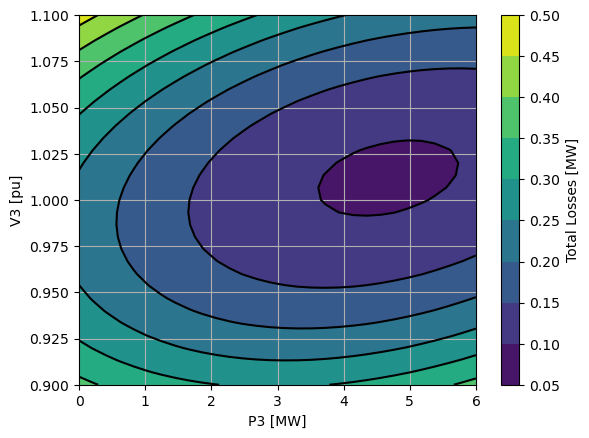

In [6]:
P3_vals = np.linspace(0.0, 6.0, 30)
V3_vals = np.linspace(0.9, 1.1, 31)
P3_mesh, V3_mesh = np.meshgrid(P3_vals, V3_vals)
P_losses = np.zeros_like(P3_mesh)

for j, P3 in enumerate(P3_vals): 
    for i, V3 in enumerate(V3_vals): 
        u = np.array([P3, V3])
        obj = objective_function(u)
        P_losses[i, j] = obj*S_base 

plt.contour(P3_mesh, V3_mesh, P_losses, colors="black")
cp = plt.contourf(P3_mesh, V3_mesh, P_losses)
plt.colorbar(cp, label="Total Losses [MW]")
plt.xlabel("P3 [MW]")
plt.ylabel("V3 [pu]")
plt.grid()

plt.show() 

In [7]:
u0 = np.array([P3_start, V3_start])
#                                                    V1   P2    Q2
sol_OPF = minimize(objective_function, x0=u0, args=(1.0, -6.0, -4.5))
P3_opt, V3_opt = sol_OPF.x 
print(f"P3 optimal: {P3_opt} MW, V3 optimal: {V3_opt} pu, P_losses: {sol_OPF.fun*S_base} MW")

P3 optimal: 4.666680552660378 MW, V3 optimal: 1.0118064838253116 pu, P_losses: 0.09317547974836832 MW


In [8]:
P3_vals = np.linspace(0.0, 6.0, 30)
V3_vals = np.linspace(0.9, 1.1, 31)
P3_mesh, V3_mesh = np.meshgrid(P3_vals, V3_vals)
P_losses = np.zeros_like(P3_mesh)

for j, P3 in enumerate(P3_vals): 
    for i, V3 in enumerate(V3_vals): 
        u = np.array([P3, V3])
        obj = objective_function(u)
        P_losses[i, j] = obj*S_base 

# Defining OPF constraints in Python
[](#Constraints)

## Voltage and power constraints 
All buses should have a minimum and maximum voltage, active power, and reactive power constraint. 

$$ V_i^{min} \le V_i \le V_i^{max} \, \forall i\in N_{bus}$$

$$ P_i^{min} \le P_i \le P_i^{max} \, \forall i \in N_{gen} $$

$$ Q_i^{min} \le Q_i \le Q_i^{max} \, \forall i \in N_{gen} $$

In reality, the reactive power limits are determined by the generator capability diagram. However, for the sake of simplicity, we use hard-coded limits for these limits. 

## Line flow constraints
[](#LineFlowConstraints)

In this notebook there will be used the line currents between two busbars. A useful matrix definition to calculate all line currents is shown below. 

$$ \textbf{Y}_{lines} = \begin{bmatrix} y_{11}^{shunt} & y_{12} & ... & y_{1n} \\ 
                                      y_{21} & y_{22}^{shunt} & ... & V_2-V_n \\ 
                                      y_{31} & y{32} & ... & y{3n} \\ 
                                      ... & ... & ... & ... \\ 
                                      y_{n1} & y_{n2} & ... & y_{nn}^{shunt} \end{bmatrix} $$

In our cases, $y_{ii}^{shunt} = 0 \forall i \in N_{bus}$

$$ \textbf{V} = \begin{bmatrix} V_1 & V_1-V_2 & ... & V_1-V_n \\ 
                                V_2-V_1 & V_2 & ... & V_2-V_n \\ 
                                V_3-V_1 & V_3-V_2 & ... & V_3-V_n \\ 
                                ... & ... & ... & ... \\ 
                                V_n-V_1 & V_n-V_2 & ... & V_n \end{bmatrix} $$

$$ \textbf{I} = \begin{bmatrix} I_{11} & I_{12} & ... & I_{1n} \\ 
                                I_{21} & I_{22} & ... & I_{2n} \\ 
                                I_{31} & I_{32} & ... & I_{3n} \\ 
                                ... & ... & ... & ... \\ 
                                I_{n1} & I_{n2} & ... & I_{nn} \end{bmatrix} = \textbf{V} \textbf{Y}_{lines} $$

All lines should have a maximum allowed current through it, such that 

$$ |I_{ij}| \le I_{ij}^{max} \, \forall i, j \in N_{bus} $$

Note that the constraints mentioned above are non-linear constraints. Therefore, we need to use Scipy's **NonlinearConstraint** class when defining the constraint. Read more about that [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.NonlinearConstraint.html#scipy.optimize.NonlinearConstraint). 

In [9]:
from numeric_data import Y_lines
from scipy.optimize import NonlinearConstraint

# Defining the equations above: 
def get_I_mat(V_vec, Y_lines):         
    V_mat = np.zeros((len(V_vec), len(V_vec)), dtype=np.complex64)
    for idx, V in enumerate(V_vec):
        V_mat[idx] = -V_vec
        V_mat[idx] += V
        V_mat[idx, idx] = V   
    I_mat = V_mat * Y_lines
    return I_mat 

def objective_function(u, V1=1.0, P2=-6.0, Q2=-4.5): 
    P3, V3 = u 
    th_OPF = np.array([0.0, 0.0, 0.0], dtype=float) #initialize
    V_OPF = np.array([V1, 1.0, V3], dtype=float) 
    P_OPF = np.array([0.0, P2, P3])/S_base 
    Q_OPF = np.array([0.0, Q2, 0.0])/S_base 
    th_res, V_res, P_res, Q_res = get_pf_sol(th_OPF, V_OPF, P_OPF, Q_OPF)    
    return np.sum(P_res)*S_base # Returns the difference between P in and out, hence transmission losses

def opf_constraints(u, V1=1.0, P2=-6.0, Q2=-4.5): 
    P3, V3 = u 
    th_OPF = np.array([0.0, 0.0, 0.0], dtype=float) #initialize
    V_OPF = np.array([V1, 1.0, V3], dtype=float) 
    P_OPF = np.array([0.0, P2, P3])/S_base 
    Q_OPF = np.array([0.0, Q2, 0.0])/S_base 
    th_res, V_res, P_res, Q_res = get_pf_sol(th_OPF, V_OPF, P_OPF, Q_OPF)    
    V_complex = V_res*(np.cos(th_res)+1j*np.sin(th_res))
    I_mat_pu = get_I_mat(V_complex, Y_lines)
    I_mat_abs = np.abs(I_mat_pu*I_base) # from pu to ampere. 
    I_12 = I_mat_abs[0, 1]
    I_13 = I_mat_abs[0, 2]
    I_23 = I_mat_abs[1, 2]

    #                               V2,       P1        Q1       Q3
    constraint_vector = np.array([V_res[1], P_res[0], Q_res[0], Q_res[2], I_12, I_13, I_23])
    return constraint_vector 


# OPF in a simple system using Scipy, with constraints
[](#OPFScipyCons) 

In [16]:
# Defining all constraints into one vector allows us to calculate the constraints only once, instead of multiple times. 
# In this case, the chosen ordering of the constraint variables are: 
# cons = [V2, P1, Q1, Q3, I_12, I_13, I_23]
# Note that we dont have any influence over V1, P2, or Q2. Therefore, we don't constrain them
const_min = [0.95, 0.0, -3.0, -3.0, 0.0, 0.0, 0.0]
const_max = [1.05, 6.0, 5.0, 5.0, 100, 100, 200]
bounds = [(0, 6.0), (0.95, 1.05)]
const = NonlinearConstraint(opf_constraints, const_min, const_max)

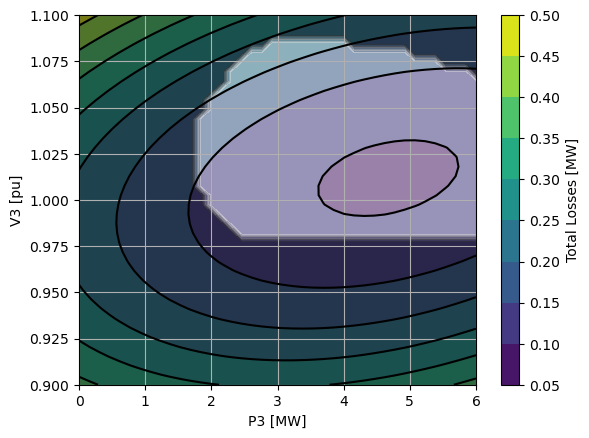

In [17]:
# Visualizing wheter the operating point is inside or outside the constraints
P3_vals = np.linspace(0.0, 6.0, 40)
V3_vals = np.linspace(0.9, 1.1, 40)
P3_mesh, V3_mesh = np.meshgrid(P3_vals, V3_vals)
P_losses = np.zeros_like(P3_mesh)
is_inside = np.zeros_like(P3_mesh)

for j, P3 in enumerate(P3_vals): 
    for i, V3 in enumerate(V3_vals): 
        u = np.array([P3, V3])
        obj = objective_function(u)
        P_losses[i, j] = obj
        const_vals = const.fun(u) 
        inside = np.logical_and(const_min <= const_vals, const_vals <= const_max).all()
        is_inside[i,j] = inside 


plt.contour(P3_mesh, V3_mesh, P_losses, colors="black")
cp = plt.contourf(P3_mesh, V3_mesh, P_losses)
plt.colorbar(cp, label="Total Losses [MW]")
plt.contourf(P3_mesh, V3_mesh, is_inside, cmap="gray", alpha=0.5)
plt.xlabel("P3 [MW]")
plt.ylabel("V3 [pu]")
plt.grid()

plt.show() 

In [18]:
u0 = np.array([6.0, 1.0])
sol_OPF = minimize(objective_function, x0=u0, constraints=const, bounds=bounds, tol=1e-5)
P3_opt, V3_opt = sol_OPF.x 
print(f"P3 optimal: {P3_opt} MW, V3 optimal: {V3_opt} pu, P_losses: {sol_OPF.fun} MW")

P3 optimal: 4.662942373373223 MW, V3 optimal: 1.0116575315419656 pu, P_losses: 0.0931758808624103 MW


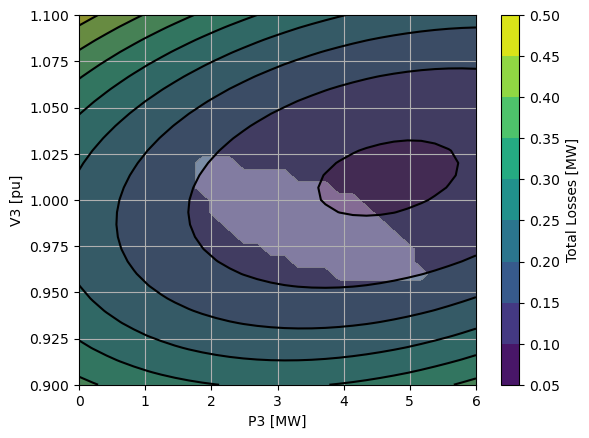

In [23]:
# cons = [V2, P1, Q1, Q3, I_12, I_13, I_23]
const_min = [0.9, 0.0, -2.0, -2.0, 0.0, 0.0, 0.0]
const_max = [1.0, 6.0,  2.0,  2.0, 100, 100, 140]
bounds = [(0, 6.0), (0.95, 1.05)]
const = NonlinearConstraint(opf_constraints, const_min, const_max, jac="3-point")

# Visualizing wheter the operating point is inside or outside the constraints
P3_vals = np.linspace(0.0, 6.0, 30)
V3_vals = np.linspace(0.9, 1.1, 31)
P3_mesh, V3_mesh = np.meshgrid(P3_vals, V3_vals)
P_losses = np.zeros_like(P3_mesh)
is_inside = np.zeros_like(P3_mesh)

for j, P3 in enumerate(P3_vals): 
    for i, V3 in enumerate(V3_vals): 
        u = np.array([P3, V3])
        obj = objective_function(u)
        P_losses[i, j] = obj
        const_vals = const.fun(u) 
        inside = np.logical_and(const_min <= const_vals, const_vals <= const_max).all()
        is_inside[i,j] = inside 


plt.contour(P3_mesh, V3_mesh, P_losses, colors="black")
cp = plt.contourf(P3_mesh, V3_mesh, P_losses)
plt.colorbar(cp, label="Total Losses [MW]")
plt.contourf(P3_mesh, V3_mesh, is_inside, cmap="gray", alpha=0.5, levels=1)
plt.xlabel("P3 [MW]")
plt.ylabel("V3 [pu]")
plt.grid()

plt.show() 

In [24]:
u0 = np.array([6.0, 0.9])
sol_OPF = minimize(objective_function, x0=u0, constraints=const, bounds=bounds, jac="3-point")
P3_opt, V3_opt = sol_OPF.x 
print(f"P3 optimal: {P3_opt} MW, V3 optimal: {V3_opt} pu, P_losses: {sol_OPF.fun*S_base} MW")

P3 optimal: 4.13147560905889 MW, V3 optimal: 1.0010192307779078 pu, P_losses: 9.589849570458275 MW


#### End of Notebook
---